In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore')       # Elimina las advertencias de código

<p style="text-align:center">
    <font size="8" style="color:darkred">
        <div style="text-align:center">
        Modelo Dinámico de Consumo Keynesiano
        </div>
    </font>

Siguiendo la teoría del consumo presentado en la Notebook previa, aquí se realizará un modelo económico basado en series de tiempo para extender la relación dinámica del consumo con sus rezagos y con ciertas variables exógenas.

En este modelo se usará el Indicador Global de la Actividad Económica $(Y)$ como proxy del ingreso y el Indicador Mensual del Consumo Privado en el Mercado Interior $(C)$ como representante del consumo. Para mejor interpretación de los resultados se usará el crecimiento porcentual anual de ambas series.

In [2]:
data = pd.read_csv('../data/Consumo Indices.csv', parse_dates=['Periodos'], index_col='Periodos', infer_datetime_format=True)

data['CAC'] = data['C'].pct_change(12)*100      # Serie de tiempo compuesta por el crecimiento porcentual anual
data['CAY'] = data['Y'].pct_change(12)*100

data = data.dropna()
data.head()

,C,Y,CAC,CAY
Periodos,,,,
1994-01-01,59.000750,64.366823,4.021217,4.365599
1994-02-01,59.498099,64.416448,3.572952,2.928492
1994-03-01,59.563671,65.022399,1.898095,4.326403
1994-04-01,61.360720,65.897192,5.770350,5.511442
1994-05-01,61.434244,65.879617,4.292338,4.525662


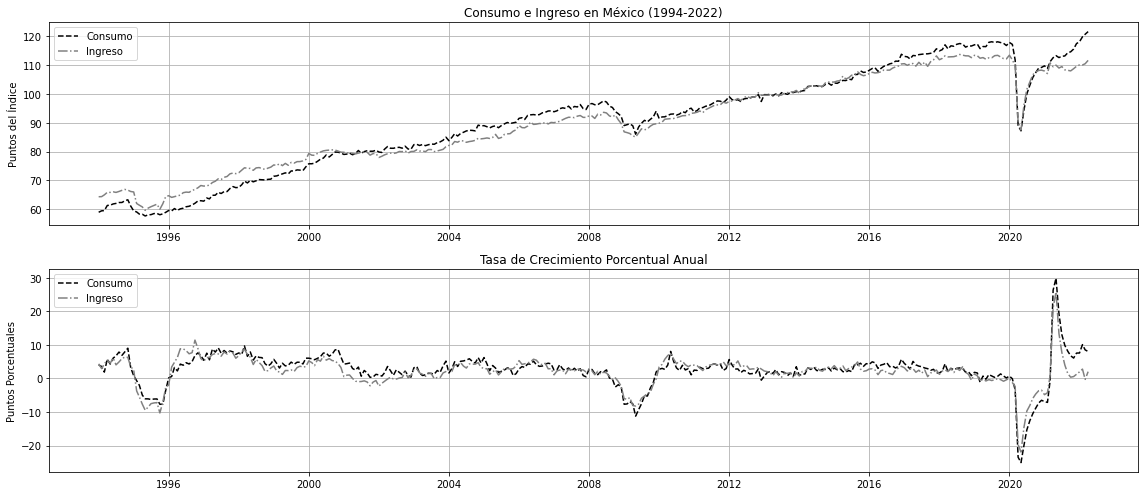

In [3]:
fig, axes = plt.subplots(2, figsize=(16, 7))

ax = axes[0]
ax.plot(data['C'], label='Consumo', color='black', linestyle='--')
ax.plot(data['Y'], label='Ingreso', color='gray', linestyle='-.')
ax.set(title='Consumo e Ingreso en México (1994-2022)')
ax.set_ylabel('Puntos del Índice')
ax.legend()
ax.grid(True)


ax = axes[1]
ax.plot(data['CAC'], label='Consumo', color='black', linestyle='--')
ax.plot(data['CAY'], label='Ingreso', color='gray', linestyle='-.')
ax.set(title='Tasa de Crecimiento Porcentual Anual')
ax.set_ylabel('Puntos Porcentuales')
ax.grid(True)
ax.legend()

fig.tight_layout()

Para modelar un modelo de series de tiempo se debe garantizar que sean procesos estacionarios, normalmente se transforma la serie para que tenga esa característica. Lo que usualmente se hace es aplicar diferencias en la serie, aplicar logaritmos o usar tasas de crecimiento. En python se usa el método diff() para obtener la diferencia y pct_change() para una tasa de crecimiento. Para contrastar el comportamiento de ambos casos, se realizó un DataFrame y una gráfica que permite ver semejanzas y diferencias.

In [4]:
white_noise = data[['CAC','CAY']].copy()
white_noise['dC'] = data['C'].diff(12)
white_noise['dY'] = data['Y'].diff(12)
white_noise = white_noise.dropna()

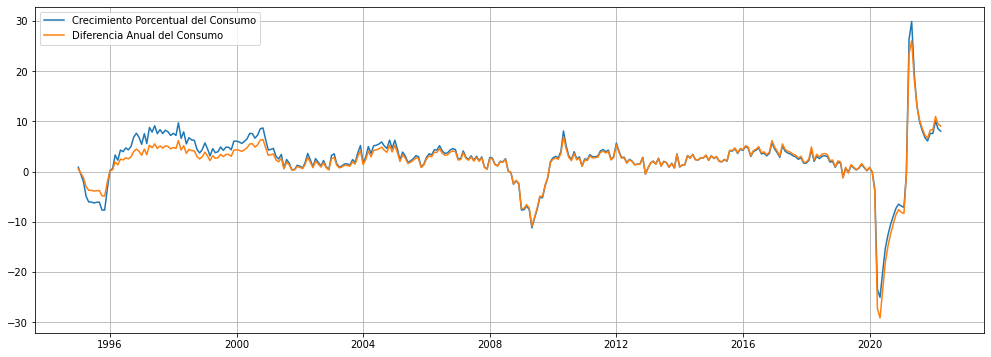

In [5]:
plt.figure(figsize=[17,6])

plt.plot(white_noise['CAC'], label='Crecimiento Porcentual del Consumo')
plt.plot(white_noise['dC'], label='Diferencia Anual del Consumo')

plt.grid()
plt.legend()
plt.show()

Para garantizar la existencia de estacionariedad se realiza la prueba Dickey-Fuller Aumentada. Como ya existe una función que permite realizar esa prueba, sólo se llamará y utilizará, sin embargo, es prudente que se revise la metodología para una mayor comprensión, en especial a los casos referentes a la tendencia. En ese sentido, se realizó e importó una función, disponible en el archivo **Funciones.py**, que calcula y plasma en un DataFrame el valor-p de la prueba Dickey-Fuller para cada serie, aquí se busca un valor lo más cercano a 0. Tenga presente que la función es sencilla porque es para uso personal o para personas con conocimientos en la materia.

In [6]:
import Funciones
Funciones.Cuadro_Dickey_Fuller(data)

,n,c,ct,ctt
C,0.988148,0.828943,0.069045,0.031027
Y,0.981487,0.759084,0.045840,0.056749
CAC,0.028026,0.003990,0.021495,0.133287
CAY,0.009321,0.001311,0.004495,0.043163


El DataFrame permite ver que las series CAC y CAY son estacionarias, entonces, se procede a graficar las funciones de autocorrelación y autocorrelación parcial de la serie CAC para poder proponer el orden $AR$ y $MA$ del modelo de consumo.

In [7]:
from statsmodels.graphics import tsaplots

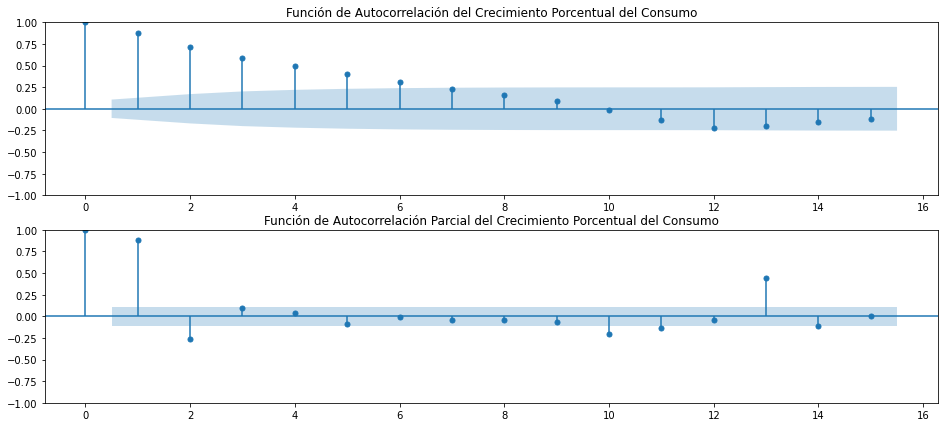

In [8]:
fig, axes = plt.subplots(2, figsize=(16, 7))

tsaplots.plot_acf(data['CAC'], lags=15, ax=axes[0], title='Función de Autocorrelación del Crecimiento Porcentual del Consumo')
tsaplots.plot_pacf(data['CAC'], lags=15, ax=axes[1], title='Función de Autocorrelación Parcial del Crecimiento Porcentual del Consumo');

La función de autocorrelación permite proponer un modelo $MA(6)$ ordinario, en cambio, la función de autocorrelación parcial hace proponer un $AR(2)$ ordinario. La función del modelo SARIMAX solicita en el argumento order lo siguiente: $(p,d,q)$. El valor $p$ hace referencia al $AR$, $q$ al $MA$ y $d$ al orden de integración que es determinado por la cantidad de veces que la serie debe ser diferenciada. En nuestro caso no se necesitó diferenciar la serie, por lo tanto, el orden de integración es 0.

Para determinar el orden del modelo se usan los criterios de información. Sin embargo, cada posible combinación de $p$ y $q$ hace que se tenga una gran cantidad de opciones, por lo tanto, se seguirán las recomendaciones y el código elaborado por el doctor <a ref='https://randall-romero.github.io/econometria/teoria/03-arma/05-estimacion.html#distinguiendo-los-procesos-ar-p-de-los-ma-q'>Randall Romero</a>. Se recomienda revisar sus apuntes y seguir su trabajo. Ajusté su código para realizar funciones que puedan ser ejecutadas cuando se desee sin la necesidad de buscar el código, sin embargo, se recomienda usar la función con mucha cautela, en especial al seleccionar la cantidad de $p$ y $q$, pero eso ya depende de la capacidad del PC.

De acuerdo con los apuntes de Romero, entre menos valores $p$ y $q$, se tendrá una mejor estimación. Entonces, se usará la menor cantidad de valores $p$ y $q$ usando que presenten el criterio de información más bajo.

In [9]:
Funciones.select_order_akaike(data['CAC'], AR=6, MA=6, Trend='c')

,q=0,q=1,q=2,q=3,q=4,q=5,q=6
p=0,2063.341858,1766.311021,1633.374542,1591.384488,1568.423210,1538.885422,1524.546903
p=1,1561.312120,1539.366852,1540.912570,1540.286193,1541.848046,1543.545104,1520.685730
p=2,1541.074347,1541.123656,1541.204481,1541.917515,1543.916471,1540.503199,1496.401677
p=3,1540.142695,1541.983921,1515.436748,1524.282141,1514.296408,1519.013215,1505.374610
p=4,1541.682530,1542.574696,1543.811649,1515.705096,1520.916036,1509.350153,1504.943963
p=5,1541.187579,1540.203825,1541.720530,1547.755047,1481.268165,1482.791645,1494.527362
p=6,1543.156174,1545.186394,1530.816924,1530.474059,1488.096423,1516.329982,1520.371473


In [10]:
Funciones.select_order_bayes(data['CAC'], AR=6, MA=6, Trend='c')

,q=0,q=1,q=2,q=3,q=4,q=5,q=6
p=0,2070.999750,1777.797858,1648.690324,1610.529216,1591.396884,1565.688041,1555.178468
p=1,1572.798957,1554.682634,1560.057298,1563.259867,1568.650665,1574.176669,1555.146241
p=2,1556.390130,1560.268384,1564.178155,1568.720134,1574.548036,1574.963710,1534.691133
p=3,1559.287423,1564.957595,1542.239367,1554.913706,1548.756919,1557.302671,1547.493011
p=4,1564.656204,1569.377315,1574.443214,1550.165607,1559.205493,1551.468555,1550.891311
p=5,1567.990199,1570.835390,1576.181040,1586.044503,1523.386566,1528.738993,1544.303655
p=6,1573.787739,1579.646905,1569.106380,1572.592461,1534.043770,1566.106275,1573.976711


In [11]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [12]:
model = SARIMAX(data['CAC'], order=(5,0,4), trend='c')
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    CAC   No. Observations:                  340
Model:               SARIMAX(5, 0, 4)   Log Likelihood                -729.634
Date:                Fri, 02 Sep 2022   AIC                           1481.268
Time:                        11:37:25   BIC                           1523.387
Sample:                    01-01-1994   HQIC                          1498.051
                         - 04-01-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      2.6925      1.059      2.544      0.011       0.618       4.767
ar.L1         -0.4404      0.066     -6.630      0.000      -0.571      -0.310
ar.L2         -0.2370      0.057     -4.155      0.000      -0.349      -0.125
ar.L3         -0.0299      0.063     -0.471      0.637      -0.154       0.094
ar.L4          0.3351      0.064      5.247      0.000       0.210       0.460
ar.L5          0.4638      0.062      7.454      0.000       0.342       0.586
ma.L1          1.6828      0.534      3.152      0.002       0.636       2.729
ma.L2          1.9185      0.594      3.228      0.001       0.753       3.084
ma.L3          1.6686      0.494      3.381      0.001       0.701       2.636
ma.L4          0.9914      0.606      1.635      0.102      -0.197       2.180
sigma2         4.1210      2.414      1.707      0.088      -0.610       8.852
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):             19509.45
Prob(Q):                              0.91   Prob(JB):                         0.00
Heteroskedasticity (H):               4.37   Skew:                            -0.45
Prob(H) (two-sided):                  0.00   Kurtosis:                        40.10
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Los valores-p en este modelo comprueban la existencia de problemas en la normalidad y heterocedasticidad de los residuos. Los siguientes gráficos permiten observar dichos problemas, además de un fuerte sesgo en la información a partir del 2020.

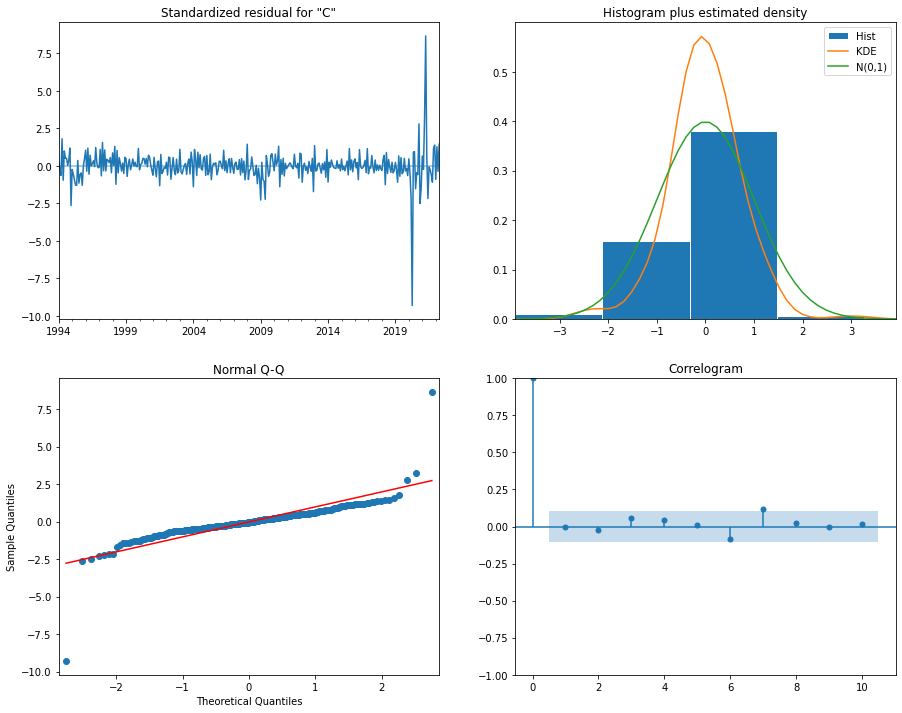

In [13]:
results.plot_diagnostics(figsize=[15,12]);

El modelo anterior sólo considera el comportamiento dinámico del Consumo, es decir, la relación que tiene con sus rezagos. Se añadirá el ingreso como una variable exógena para seguir la teoría económica y se espera tener un mejor comportamiento en los residuos. En la siguiente celda se muestran los correlogramas del ingreso, pero no es necesario realizarlo.

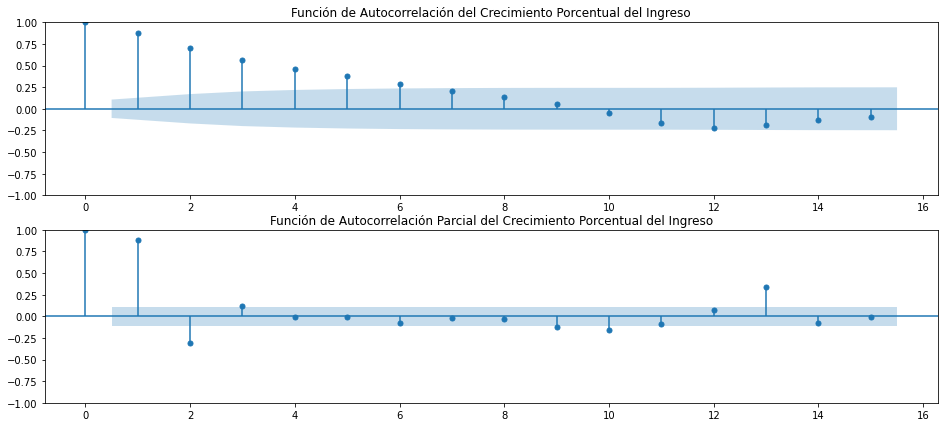

In [14]:
fig, axes = plt.subplots(2, figsize=(16, 7))

tsaplots.plot_acf(data['CAY'], lags=15, ax=axes[0], title='Función de Autocorrelación del Crecimiento Porcentual del Ingreso')
tsaplots.plot_pacf(data['CAY'], lags=15, ax=axes[1], title='Función de Autocorrelación Parcial del Crecimiento Porcentual del Ingreso');

In [15]:
Funciones.select_order_akaike(data['CAC'], AR=6, MA=6, Exog=data['CAY'], Trend='c')

,q=0,q=1,q=2,q=3,q=4,q=5,q=6
p=0,1461.466152,1300.351292,1222.186631,1188.480782,1170.671419,1130.590494,1130.969007
p=1,1139.694461,1113.458669,1113.926661,1114.547099,1113.939890,1115.464209,1105.231872
p=2,1114.006108,1114.272974,1106.460074,1107.044062,1098.056756,1095.193745,1102.885090
p=3,1114.072175,1116.054572,1102.786455,1118.793841,1090.003733,1095.449412,1085.067323
p=4,1116.020032,1117.858280,1111.989874,1095.856039,1079.858561,1087.756896,1086.645413
p=5,1116.419098,1111.482649,1097.585937,1085.335085,1083.511210,1088.499413,1077.920747
p=6,1115.463955,1112.494187,1095.813957,1098.025430,1073.775735,1076.460334,1079.926120


In [16]:
Funciones.select_order_bayes(data['CAC'], AR=6, MA=6, Exog=data['CAY'], Trend='c')

,q=0,q=1,q=2,q=3,q=4,q=5,q=6
p=0,1472.952989,1315.667074,1241.331359,1211.454456,1197.474038,1161.222058,1165.429517
p=1,1155.010244,1132.603398,1136.900334,1141.349718,1144.571455,1149.924720,1143.521328
p=2,1133.150836,1137.246648,1133.262693,1137.675627,1132.517266,1133.483202,1145.003492
p=3,1137.045849,1142.857191,1133.418020,1153.254352,1128.293189,1137.567814,1131.014671
p=4,1142.822652,1148.489845,1146.450384,1134.145496,1121.976963,1133.704243,1136.421706
p=5,1147.050663,1145.943159,1135.875393,1127.453487,1129.458557,1138.275707,1131.525985
p=6,1149.924466,1150.783643,1137.932359,1143.972777,1123.552028,1130.065573,1137.360305


In [17]:
model = SARIMAX(data['CAC'], exog=data['CAY'], order=(4,0,4), trend='c')
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    CAC   No. Observations:                  340
Model:               SARIMAX(4, 0, 4)   Log Likelihood                -528.929
Date:                Fri, 02 Sep 2022   AIC                           1079.859
Time:                        11:38:28   BIC                           1121.977
Sample:                    01-01-1994   HQIC                          1096.641
                         - 04-01-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0246      0.020      1.206      0.228      -0.015       0.065
CAY            1.0203      0.015     67.020      0.000       0.990       1.050
ar.L1          1.6277      0.103     15.832      0.000       1.426       1.829
ar.L2          0.0297      0.117      0.253      0.800      -0.200       0.260
ar.L3         -1.3497      0.081    -16.724      0.000      -1.508      -1.192
ar.L4          0.6507      0.075      8.663      0.000       0.503       0.798
ma.L1         -1.1208      8.371     -0.134      0.893     -17.528      15.287
ma.L2         -0.4993      4.006     -0.125      0.901      -8.351       7.352
ma.L3          1.2653      9.057      0.140      0.889     -16.487      19.017
ma.L4         -0.3471      3.296     -0.105      0.916      -6.807       6.113
sigma2         1.2760     12.013      0.106      0.915     -22.269      24.821
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):                24.42
Prob(Q):                              0.80   Prob(JB):                         0.00
Heteroskedasticity (H):               0.89   Skew:                            -0.09
Prob(H) (two-sided):                  0.54   Kurtosis:                         4.30
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

La introducción de la variable ingreso, que es estadísticamente significativo, permite ver una mejoría en el comportamiento de los residuos y elimina la heterocedasticidad, pero aún se tienen problemas de normalidad.

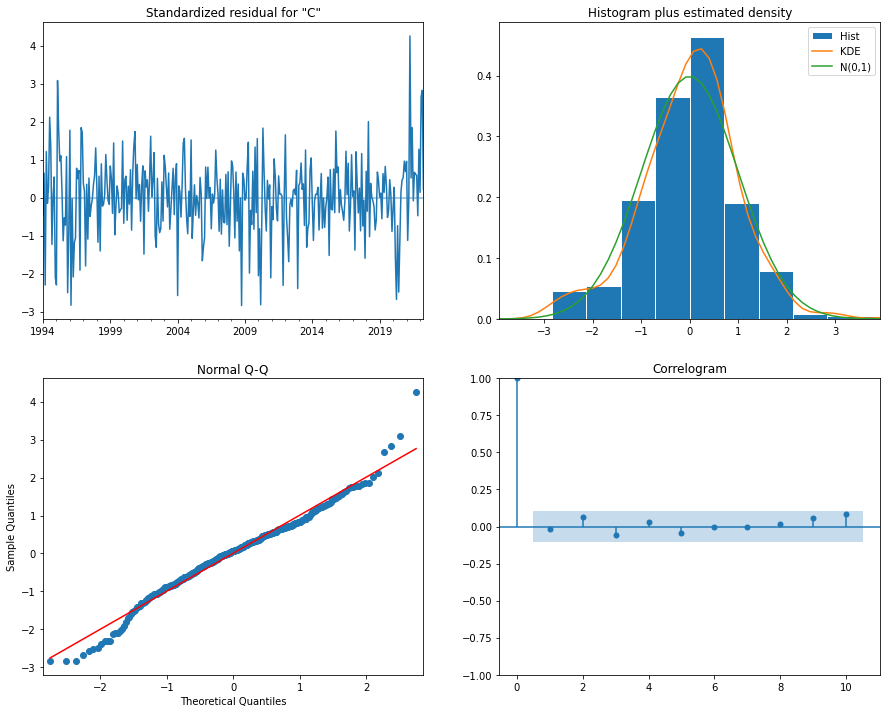

In [18]:
results.plot_diagnostics(figsize=[15,12]);

Hay algo que aún no se ha considerado, antes se mencionó que el principal sesgo proviene del 2020 en adelante y esa puede ser la razón de la asimetría en los datos. Entonces, se procede a encapsular los periodos donde el consumo fue negativo. Se tiene tres momentos principales, la crisis local llamada *"Error de Diciembre"*, la crisis mobiliaria de 2008 y la crisis del COVID-19.

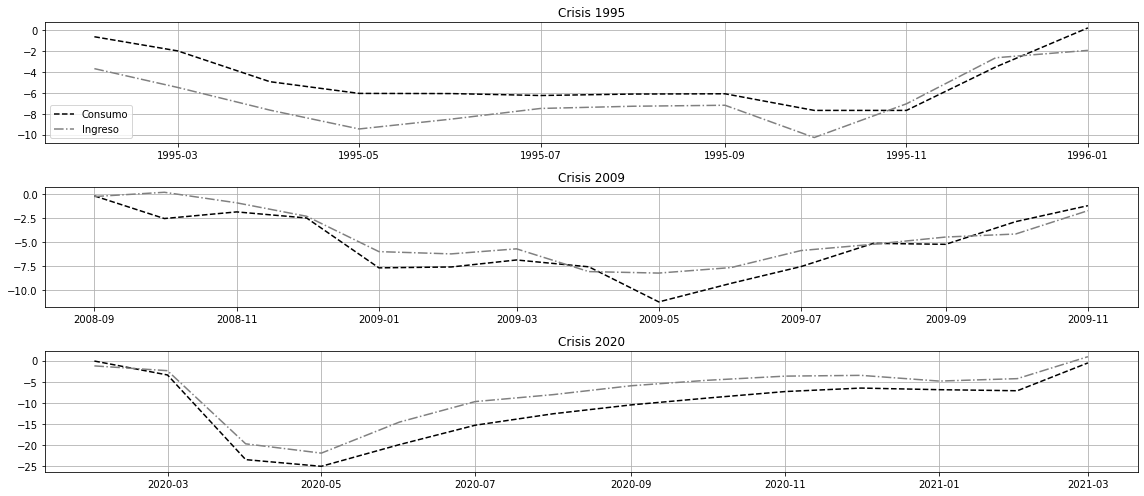

In [19]:
fig, axes = plt.subplots(3, figsize=(16, 7))

ax = axes[0]
ax.plot(data['CAC'][13:25], label='Consumo', color='black', linestyle='--')
ax.plot(data['CAY'][13:25], label='Ingreso', color='gray', linestyle='-.')
ax.set(title='Crisis 1995')
ax.legend()
ax.grid(True)


ax = axes[1]
ax.plot(data['CAC'][176:191], label='Consumo', color='black', linestyle='--')
ax.plot(data['CAY'][176:191], label='Ingreso', color='gray', linestyle='-.')
ax.set(title='Crisis 2009')
ax.grid(True)

ax = axes[2]
ax.plot(data['CAC'][313:327], label='Consumo', color='black', linestyle='--')
ax.plot(data['CAY'][313:327], label='Ingreso', color='gray', linestyle='-.')
ax.set(title='Crisis 2020')
ax.grid(True)

fig.tight_layout()

Una vez que se obtuvieron los datos que representan esos momentos, se realiza una variable llamada *"Crisis"* con valores 0 que representaría un comportamiento positivo y 1 para los momentos de crisis.

In [20]:
data['Crisis'] = 0
data['Crisis'][13:25] = 1
data['Crisis'][176:191] = 1
data['Crisis'][313:337] = 1
data

,C,Y,CAC,CAY,Crisis
Periodos,,,,,
1994-01-01,59.000750,64.366823,4.021217,4.365599,0
1994-02-01,59.498099,64.416448,3.572952,2.928492,0
1994-03-01,59.563671,65.022399,1.898095,4.326403,0
1994-04-01,61.360720,65.897192,5.770350,5.511442,0
1994-05-01,61.434244,65.879617,4.292338,4.525662,0
...,...,...,...,...,...
2021-12-01,117.420829,109.555974,7.567426,1.235131,1
2022-01-01,118.050482,110.028671,7.593409,1.960567,1
2022-02-01,119.756101,110.011029,10.085507,2.792424,0


In [21]:
Funciones.select_order_akaike(data['CAC'], AR=6, MA=6, Exog=data[['CAY','Crisis']], Trend='c')

,q=0,q=1,q=2,q=3,q=4,q=5,q=6
p=0,1462.779738,1301.852358,1222.180548,1189.273091,1172.093726,1128.293954,1129.607739
p=1,1138.810757,1112.828663,1113.467210,1114.306902,1112.818455,1114.069979,1105.189476
p=2,1113.347796,1113.730738,1106.114754,1106.707265,1098.131302,1095.790485,1099.732864
p=3,1113.661942,1115.607504,1108.894388,1101.674521,1089.229453,1094.346228,1084.439086
p=4,1115.491122,1117.315066,1112.406070,1117.882276,1079.535555,1081.173806,1080.717159
p=5,1116.129322,1110.687939,1113.668252,1078.765040,1077.270735,1091.895088,1077.438805
p=6,1114.305722,1111.199136,1092.436520,1079.790040,1072.064684,1080.324783,1078.900610


In [22]:
Funciones.select_order_bayes(data['CAC'], AR=6, MA=6, Exog=data[['CAY','Crisis']], Trend='c')

,q=0,q=1,q=2,q=3,q=4,q=5,q=6
p=0,1478.095520,1320.997087,1245.154222,1216.075710,1202.725291,1162.754465,1167.897195
p=1,1157.955485,1135.802337,1140.269829,1144.938467,1147.278966,1152.359435,1147.307878
p=2,1136.321470,1140.533357,1136.746319,1141.167776,1136.420758,1137.908886,1145.680211
p=3,1140.464561,1146.239069,1143.354899,1139.963977,1131.347854,1140.293576,1134.215379
p=4,1146.122687,1151.775577,1150.695526,1160.000678,1125.482902,1130.950099,1134.322398
p=5,1150.589833,1148.977395,1155.786653,1124.712387,1127.047028,1145.500326,1134.872989
p=6,1152.595178,1153.317538,1138.383867,1129.566333,1125.669923,1137.758967,1140.163740


In [23]:
model = SARIMAX(data['CAC'], exog=data[['CAY','Crisis']], order=(5,0,3), trend='c')
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    CAC   No. Observations:                  340
Model:               SARIMAX(5, 0, 3)   Log Likelihood                -527.383
Date:                Fri, 02 Sep 2022   AIC                           1078.765
Time:                        11:39:46   BIC                           1124.712
Sample:                    01-01-1994   HQIC                          1097.073
                         - 04-01-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0982      0.125      0.783      0.433      -0.148       0.344
CAY            1.0245      0.014     71.598      0.000       0.996       1.053
Crisis         1.0675      0.267      4.004      0.000       0.545       1.590
ar.L1          0.5811      0.055     10.583      0.000       0.474       0.689
ar.L2          0.2267      0.059      3.858      0.000       0.112       0.342
ar.L3         -0.6930      0.056    -12.442      0.000      -0.802      -0.584
ar.L4          0.4454      0.062      7.230      0.000       0.325       0.566
ar.L5          0.2134      0.068      3.135      0.002       0.080       0.347
ma.L1         -0.0330      0.509     -0.065      0.948      -1.031       0.965
ma.L2         -0.0430      0.524     -0.082      0.935      -1.070       0.984
ma.L3          0.9893      0.497      1.991      0.046       0.016       1.963
sigma2         1.2844      0.667      1.925      0.054      -0.023       2.592
===================================================================================
Ljung-Box (L1) (Q):                   0.13   Jarque-Bera (JB):                42.46
Prob(Q):                              0.72   Prob(JB):                         0.00
Heteroskedasticity (H):               1.02   Skew:                             0.04
Prob(H) (two-sided):                  0.91   Kurtosis:                         4.73
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

La variable *Crisis* tiene un fuerte efecto en el consumo, el coeficiente resulta positivo y tiene sentido porque la gente se anticipa a un futuro incierto, es decir, su consumo se basa en anticiparse a un futuro complejo.

La probabilidad de la prueba Ljung-Box dice que los residuos son independientes entre sí, es decir, no existe correlación. La prueba de heterocedasticidad también confirma la presencia de homocedasticidad en los residuos, pero aún presenta problemas de normalidad. Todo se confirma con los siguientes gráficos y, a pesar de que aún tiene problemas, resulta un mejor modelo que los anteriores. Puede que otro sesgo sea por la comparación entre los años 2020, 2021 y 2022, es decir, en el año 2020, el consumo tuvo un comportamiento tan bajo que hace parecer al 2021 como un año bastante optimista y lo mismo pasa para el 2022, por lo anterior, se puede agregar una variable cualitativa para modelar ese evento y crear un mejor modelo.

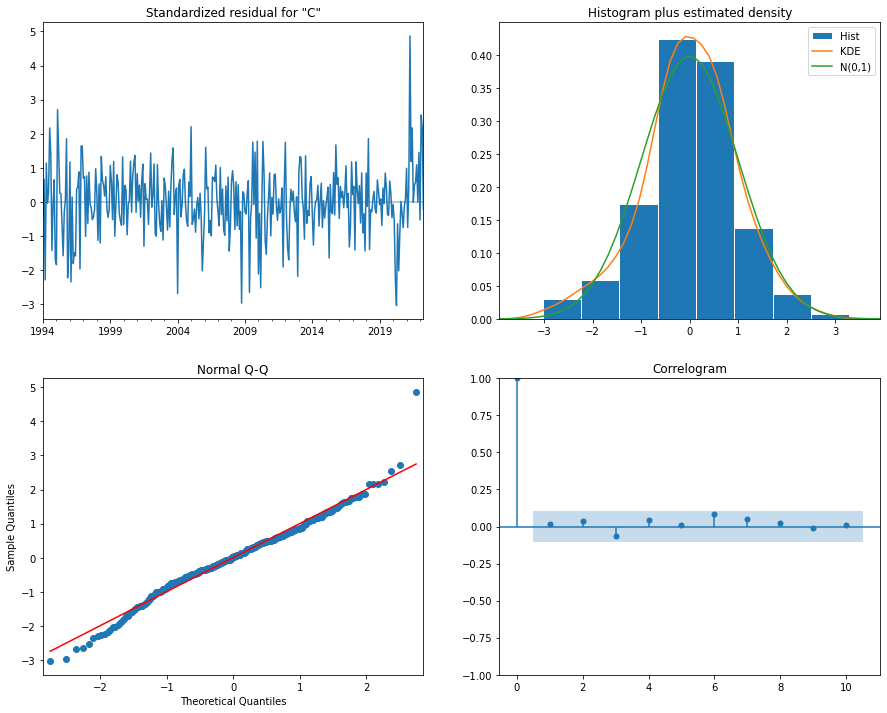

In [24]:
results.plot_diagnostics(figsize=[15,12]);

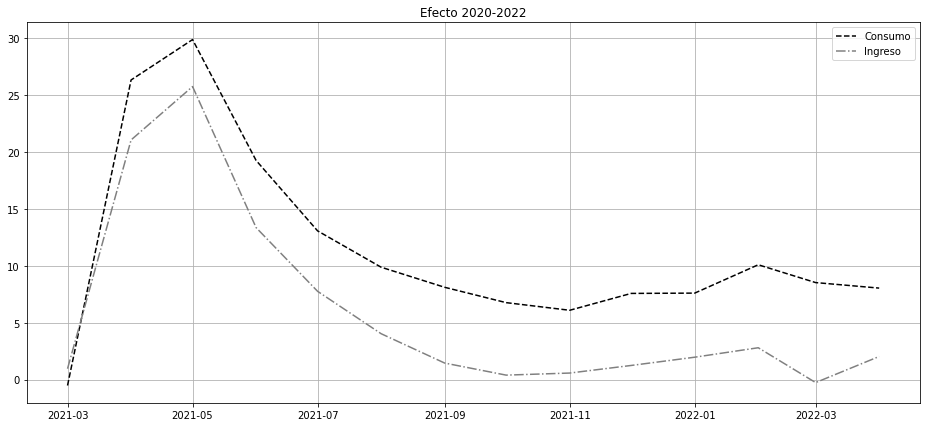

In [25]:
fig, ax = plt.subplots(figsize=(16, 7))

ax = ax
ax.plot(data['CAC'][326:], label='Consumo', color='black', linestyle='--')
ax.plot(data['CAY'][326:], label='Ingreso', color='gray', linestyle='-.')
ax.set(title='Efecto 2020-2022')
ax.legend()
ax.grid(True)

In [26]:
data['Efecto'] = 0
data['Efecto'][326:] = 1
data

,C,Y,CAC,CAY,Crisis,Efecto
Periodos,,,,,,
1994-01-01,59.000750,64.366823,4.021217,4.365599,0,0
1994-02-01,59.498099,64.416448,3.572952,2.928492,0,0
1994-03-01,59.563671,65.022399,1.898095,4.326403,0,0
1994-04-01,61.360720,65.897192,5.770350,5.511442,0,0
1994-05-01,61.434244,65.879617,4.292338,4.525662,0,0
...,...,...,...,...,...,...
2021-12-01,117.420829,109.555974,7.567426,1.235131,1,1
2022-01-01,118.050482,110.028671,7.593409,1.960567,1,1
2022-02-01,119.756101,110.011029,10.085507,2.792424,0,1


In [27]:
Funciones.select_order_akaike(data['CAC'], AR=6, MA=6, Exog=data[['CAY','Crisis','Efecto']], Trend='c')

,q=0,q=1,q=2,q=3,q=4,q=5,q=6
p=0,1333.467391,1229.003582,1179.222383,1157.112687,1140.260819,1112.344797,1113.202429
p=1,1129.434952,1097.189823,1098.368033,1099.781617,1099.220492,1100.987068,1098.923796
p=2,1100.291054,1098.478032,1095.612163,1096.507154,1088.602874,1087.578626,1089.266741
p=3,1098.973519,1100.379767,1089.013669,1088.263193,1089.976906,1085.055175,1078.882718
p=4,1099.645052,1101.532249,1080.689245,1096.891872,1075.673637,1085.110157,1075.588857
p=5,1101.288179,1099.905337,1084.364358,1102.945791,1067.935687,1074.296817,1088.808850
p=6,1101.340272,1100.864839,1085.372802,1070.823727,1066.453952,1086.841078,1073.501506


In [28]:
Funciones.select_order_bayes(data['CAC'], AR=6, MA=6, Exog=data[['CAY','Crisis','Efecto']], Trend='c')

,q=0,q=1,q=2,q=3,q=4,q=5,q=6
p=0,1352.612120,1251.977256,1206.025002,1187.744252,1174.721330,1150.634253,1155.320831
p=1,1152.408626,1123.992442,1128.999598,1134.242128,1137.509948,1143.105469,1144.871143
p=2,1127.093674,1129.109597,1130.072674,1134.796610,1130.721276,1133.525974,1139.043034
p=3,1129.605084,1134.840277,1127.303125,1130.381595,1135.924254,1134.831468,1132.487957
p=4,1134.105562,1139.821705,1122.807646,1142.839219,1125.449930,1138.715395,1133.023041
p=5,1139.577635,1142.023738,1130.311705,1152.722084,1121.540926,1131.731001,1150.071980
p=6,1143.458673,1146.812186,1135.149095,1124.428966,1123.888136,1148.104208,1138.593582


In [29]:
model = SARIMAX(data['CAC'], exog=data[['CAY','Crisis','Efecto']], order=(6,0,4), trend='c')
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    CAC   No. Observations:                  340
Model:               SARIMAX(6, 0, 4)   Log Likelihood                -518.227
Date:                Fri, 02 Sep 2022   AIC                           1066.454
Time:                        11:41:05   BIC                           1123.888
Sample:                    01-01-1994   HQIC                          1089.339
                         - 04-01-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1776      0.246      0.723      0.469      -0.304       0.659
CAY            0.9870      0.014     68.793      0.000       0.959       1.015
Crisis         0.8104      0.259      3.124      0.002       0.302       1.319
Efecto         4.8210      0.374     12.883      0.000       4.088       5.554
ar.L1         -0.2681      0.048     -5.612      0.000      -0.362      -0.174
ar.L2          0.2592      0.054      4.799      0.000       0.153       0.365
ar.L3         -0.2259      0.053     -4.293      0.000      -0.329      -0.123
ar.L4         -0.2218      0.055     -4.040      0.000      -0.329      -0.114
ar.L5          0.5717      0.056     10.148      0.000       0.461       0.682
ar.L6          0.2999      0.059      5.108      0.000       0.185       0.415
ma.L1          0.7440      0.051     14.558      0.000       0.644       0.844
ma.L2          0.3528      0.032     10.956      0.000       0.290       0.416
ma.L3          0.7639      0.099      7.709      0.000       0.570       0.958
ma.L4          0.9678      0.084     11.522      0.000       0.803       1.132
sigma2         1.1847      0.120      9.843      0.000       0.949       1.421
===================================================================================
Ljung-Box (L1) (Q):                   0.36   Jarque-Bera (JB):                28.46
Prob(Q):                              0.55   Prob(JB):                         0.00
Heteroskedasticity (H):               1.01   Skew:                            -0.27
Prob(H) (two-sided):                  0.96   Kurtosis:                         4.31
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

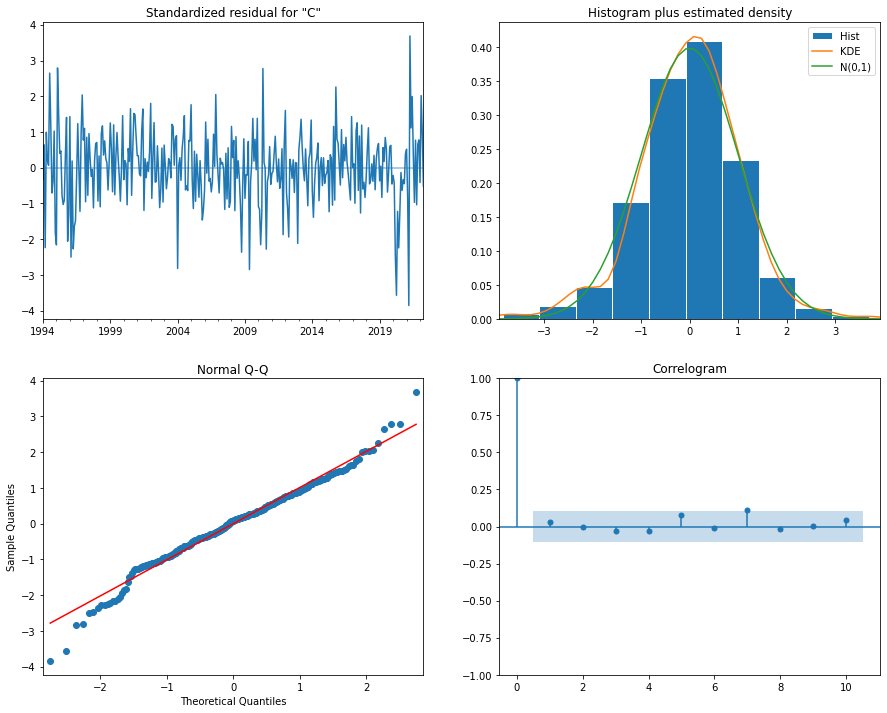

In [30]:
results.plot_diagnostics(figsize=[15,12]);

El modelo tiene un mejor comportamiento, pero sigue teniendo el problema de normalidad en los residuos.

In [31]:
forecast = results.get_forecast(steps=36, exog=data[['CAY','Crisis','Efecto']][-36:], alpha=0.05)

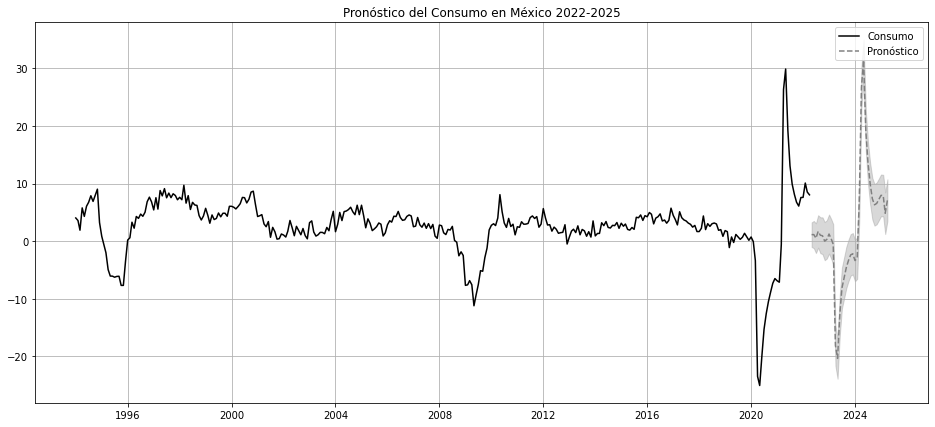

In [32]:
fig, ax = plt.subplots(figsize=(16, 7))

ax = ax
ax.plot(data['CAC'], label='Consumo', color='black')
ax.plot(forecast.predicted_mean, label='Pronóstico', color='gray', linestyle='--')
ax.fill_between(forecast.row_labels, forecast.conf_int().values[:,0], forecast.conf_int().values[:,1], color='gray', alpha=0.30)

ax.set(title='Pronóstico del Consumo en México 2022-2025')
ax.legend()
ax.grid(True)

En este punto me gustaría decir que, como se observa en la gráfica, el consumo resulta difícil de predecir al considerar el panorama complejo que se tiene en el mundo. Aunque se preveía el alza de precios por las inyecciones monetarias en la mayoría de los países, nadie se imaginó un conflicto entre Rusia y Ucrania, y peor aún, el incremento acelerado en el nivel de precios y una eventual baja en el consumo. En estos momentos es preciso decir que la *Crítica de Lucas* sigue vigente, los movimientos en materia económica, social y política se vuelven ineficaces si no existe confianza entre el Estado y la sociedad. El conocimiento de las características de una sociedad permite tener un panorama real de nuestro entorno, es decir, conocer a la población, su confianza en las instituciones, los efectos del crimen organizado, la seguridad legal y las dificultades sociales en general, permiten crear las bases necesarias para el desarrollo de estudios y políticas económicas adecuadas a partir de la teoría económica, la matemática y la econometría.